# **1. Exploring the Data**
Je suis allée prendre un dataset depuis GitHub : ``https://github.com/YoongiKim/CIFAR-10-images``

In [2]:
import os
import torch
import torchvision

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [3]:
dataset=ImageFolder('/kaggle/input/cifar10/train',transform=ToTensor())

In [4]:
len(dataset)

50000

In [5]:
img,label=dataset[0]
print(img.shape,label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7843, 0.7922, 0.7961,  ..., 0.8039, 0.7922, 0.7882],
         [0.8235, 0.8118, 0.8157,  ..., 0.8196, 0.8118, 0.8078],
         [0.8314, 0.8157, 0.8314,  ..., 0.8353, 0.8275, 0.8235],
         ...,
         [0.8588, 0.8353, 0.7569,  ..., 0.9412, 0.9333, 0.9255],
         [0.8314, 0.8510, 0.8510,  ..., 0.9686, 0.9569, 0.9294],
         [0.8667, 0.8667, 0.8627,  ..., 0.9333, 0.9451, 0.9255]],

        [[0.7922, 0.8000, 0.8039,  ..., 0.8078, 0.7961, 0.7922],
         [0.8314, 0.8196, 0.8235,  ..., 0.8235, 0.8157, 0.8118],
         [0.8392, 0.8235, 0.8392,  ..., 0.8392, 0.8314, 0.8275],
         ...,
         [0.8588, 0.8353, 0.7569,  ..., 0.9412, 0.9333, 0.9255],
         [0.8314, 0.8510, 0.8510,  ..., 0.9686, 0.9569, 0.9294],
         [0.8667, 0.8667, 0.8627,  ..., 0.9333, 0.9451, 0.9255]],

        [[0.7725, 0.7804, 0.7843,  ..., 0.7882, 0.7765, 0.7725],
         [0.8118, 0.8000, 0.8039,  ..., 0.8039, 0.7961, 0.7922],
         [0.8275, 0.8118, 0.8275,  ..., 0.8196, 0.8118, 0.

In [6]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
import matplotlib.pyplot as plt
#on change les tensor to 32*32*3 
#parce que dans matplotlib la dim de la couleur est à droite

def show_example(img,label):
    print(f'Label: {dataset.classes[label]}')
    plt.imshow(img.permute(1,2,0)) #on prend la dim 1, puis la dim 2 puis la dim 0

Label: airplane


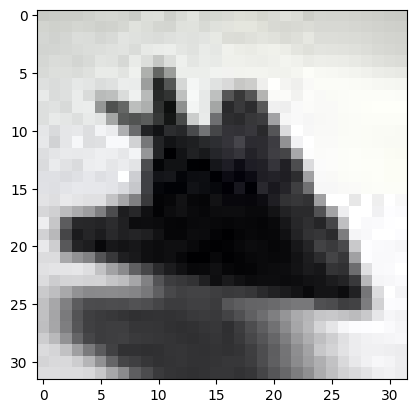

In [8]:
show_example(*dataset[0])

Label: airplane


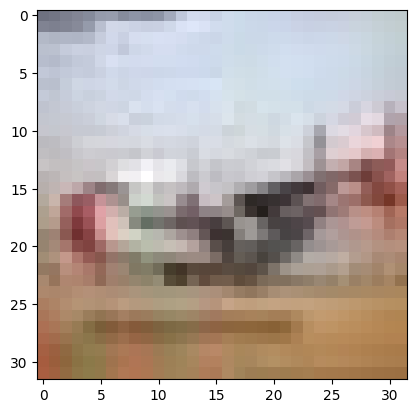

In [9]:
show_example(*dataset[1099])

# **2. Training and Validation datasets**

In [10]:
import numpy as np

def split_indices(n,val_pct=0.1,seed=42):
    #determine the size of the validation set
    n_val=int(val_pct*n)
    #set the random seed for reproductibility
    np.random.seed(seed)
    #create random permutation of 0 to n-1
    idxs=np.random.permutation(n)
    #pick first n_val indices for validation set
    return idxs[n_val:],idxs[:n_val]

In [11]:
val_pct=0.2
rand_seed=42

train_indices,val_indices=split_indices(len(dataset),val_pct,rand_seed)
print(len(train_indices),len(val_indices))
print(f'Sample validation indices: {val_indices[:10]}')

40000 10000
Sample validation indices: [33553  9427   199 12447 39489 42724 10822 49498  4144 36958]


In [12]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

batch_size=100

In [13]:
train_sampler=SubsetRandomSampler(train_indices)
train_dl=DataLoader(dataset,
                   batch_size,
                   sampler=train_sampler)
val_sampler=SubsetRandomSampler(val_indices)
val_dl=DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

# **3. Visualiser les images**

On le fait juste pour le premier batch (100 images)

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(10,10))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(images,10).permute(1,2,0))
        break

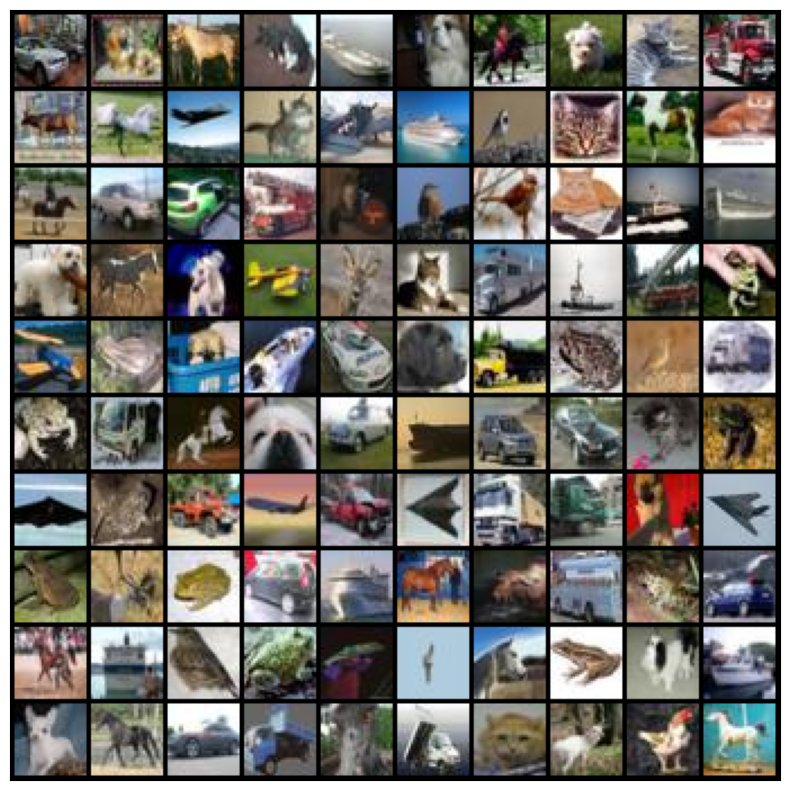

In [15]:
show_batch(train_dl)

# **4. Defining the Model (Convolutional Neural Network)**

In [16]:
import torch.nn as nn
import torch.nn.functional as F

## **1. Exemple de modèle simple**

In [17]:
simple_model=nn.Sequential(
    nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1),
    nn.MaxPool2d(2,2)
)

In [18]:
for images,labels in train_dl:
    print(f'images.shape: {images.shape}')
    out=simple_model(images)
    print(f'out.shape: {out.shape}')
    break

images.shape: torch.Size([100, 3, 32, 32])
out.shape: torch.Size([100, 8, 16, 16])


## **2. Modèle complexe**

Comment on choisit ``kernel_size`` : pour la 1ere couche, on prend la valeur du input. 

Comment on choisit ``stride`` :

Comment on choisit ``padding`` :

In [19]:
model=nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), #output : batch_size x 16 x 16 x 16

    nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), #output : bs x 16 x 8 x 8

    nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), #output : bs x 16 x 4 x 4

    nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), #output : bs x 16 x 2 x 2

    nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), #output : bs x 16 x 1 x 1

    nn.Flatten(), #output : bs x 16
    nn.Linear(16,10) #output : bs x 10
)

In [20]:
model[0].weight.shape
model[3].weight.shape

torch.Size([16, 16, 3, 3])

In [21]:
for images,labels in train_dl:
    print(f'images.shape: {images.shape}')
    out=model(images)
    print(f'out.shape: {out.shape}')
    print(f'out[0]: {out[0]}')
    break

images.shape: torch.Size([100, 3, 32, 32])
out.shape: torch.Size([100, 10])
out[0]: tensor([ 0.0908, -0.0034,  0.2451,  0.2079, -0.0371,  0.2739,  0.2047,  0.2180,
         0.2293,  0.0598], grad_fn=<SelectBackward0>)


tensor(0.1127, grad_fn=<MaxBackward1>)
Label: bird


/tmp/ipykernel_35/2550201055.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=F.softmax(out[0])


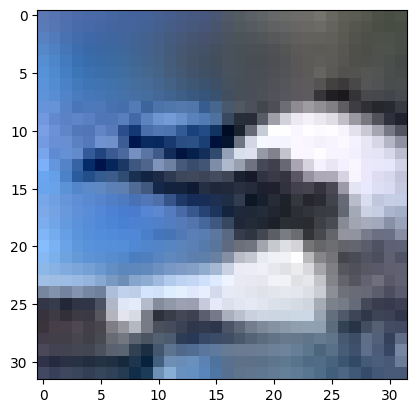

In [22]:
probs=F.softmax(out[0])
print(torch.max(probs))
probs
dataset.classes[9]
labels[0]
show_example(images[0],labels[0])

# **5. Using a GPU**

In [23]:
torch.cuda.is_available()

True

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)): #si notre dataset est une liste ou tuple
        return [to_device(x,device)for x in data]
    return data.to(device,non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device) #ca genere le batch sans repetition

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device

device(type='cuda')

In [26]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)
to_device(model,device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=16, out_features=10, bias=True)
)

# **6. Defining functions**

In [27]:
def loss_batch(model,loss_func,xb,yb,opt=None,metric=None):

    #generate predictions
    preds=model(xb)
    #calculate loss
    loss=loss_func(preds,yb)

    if opt is not None:
        #compute gradients
        loss.backward()
        #update parameters
        opt.step()
        #reset gradients
        opt.zero_grad()

    metric_result=None
    if metric is not None:
        #compute the metric
        metric_result=metric(preds,yb)

    return loss.item(),len(xb),metric_result

In [28]:
def evaluate(model,loss_fn,val_dl,metric=None):
    with torch.no_grad():
        #pass each batch through the model
        results=[loss_batch(model,loss_fn,xb,yb,metric=metric)
                for xb,yb in val_dl]
        #separate losses,counts and metrics
        losses,nums,metrics=zip(*results)
        #total size of the dataset
        total=np.sum(nums)
        #avg loss across batches
        avg_loss=np.sum(np.multiply(losses,nums))/total
        avg_metric=None
        if metric is not None:
            #avg of metric across batches
            avg_metric=np.sum(np.multiply(metrics,nums))/total

    return avg_loss,total,avg_metric

In [39]:
def fit(epochs,model,loss_fn,train_dl,val_dl,
        opt_fn=None,lr=None,metric=None):
    train_losses,val_losses,val_metrics=[],[],[]

    #instantiate the optimizer
    if opt_fn is None: 
        opt_fn=torch.optim.SGD
    opt=opt_fn(model.parameters(),lr=lr)

    for epoch in range(epochs):
        #training
        model.train() #setting de pytorch où on indique train
        for xb,yb in train_dl:
            #on fait une gradient descent pour tous les batchs 1 epoch
            train_loss,_,_=loss_batch(model,loss_fn,xb,yb,opt)

        #evaluation pour 1 epoch
        model.eval()
        result=evaluate(model,loss_fn,val_dl,metric)
        val_loss,total,val_metric=result

        #record the loss and metric pour 1 epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)

        #print progress
        if metric is None:
            print(f'Epoch [{epoch+1} / {epochs}],train_loss:{train_loss:.4f}, val_loss:{val_loss:.4f}')
        else:
            print(f'Epoch [{epoch+1} / {epochs}],train_loss:{train_loss:.4f}, val_loss:{val_loss:.4f},val_{metric.__name__} : {val_metric:.4f}')

    return train_losses,val_losses,val_metrics

In [34]:
def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.sum(preds==labels).item()/len(preds)

In [35]:
val_loss,_,val_acc=evaluate(model,F.cross_entropy,val_dl,metric=accuracy)
print(f'Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

Loss: 2.3087, Accuracy: 0.1030


# **7. Training the model**

In [37]:
num_epochs=10
opt_fn=torch.optim.Adam
lr=0.005

In [40]:
history=fit(num_epochs,model,F.cross_entropy,train_dl,val_dl,
        opt_fn,lr,accuracy)
train_losses,val_losses,val_metrics=history

Epoch [1 / 10],train_loss:1.7337, val_loss:1.6680,val_accuracy : 0.3726
Epoch [2 / 10],train_loss:1.3802, val_loss:1.4438,val_accuracy : 0.4663
Epoch [3 / 10],train_loss:1.2372, val_loss:1.4339,val_accuracy : 0.4770
Epoch [4 / 10],train_loss:1.3223, val_loss:1.3220,val_accuracy : 0.5240
Epoch [5 / 10],train_loss:1.3647, val_loss:1.2657,val_accuracy : 0.5451
Epoch [6 / 10],train_loss:1.3112, val_loss:1.2436,val_accuracy : 0.5567
Epoch [7 / 10],train_loss:1.2258, val_loss:1.3237,val_accuracy : 0.5317
Epoch [8 / 10],train_loss:1.1833, val_loss:1.2037,val_accuracy : 0.5662
Epoch [9 / 10],train_loss:1.2358, val_loss:1.2306,val_accuracy : 0.5630
Epoch [10 / 10],train_loss:1.1065, val_loss:1.2074,val_accuracy : 0.5724


In [41]:
def plot_metric(metric_values):
    plt.plot(metric_values,'-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

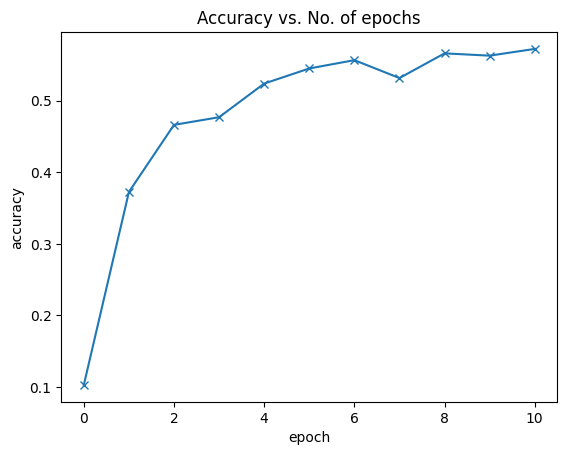

In [42]:
plot_metric([val_acc]+val_metrics)

In [43]:
def plot_losses(train_losses,val_losses):
    plt.plot(train_losses,'-x')
    plt.plot(val_losses,'-o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training','Validation'])
    plt.title('Loss vs. No. of epochs')

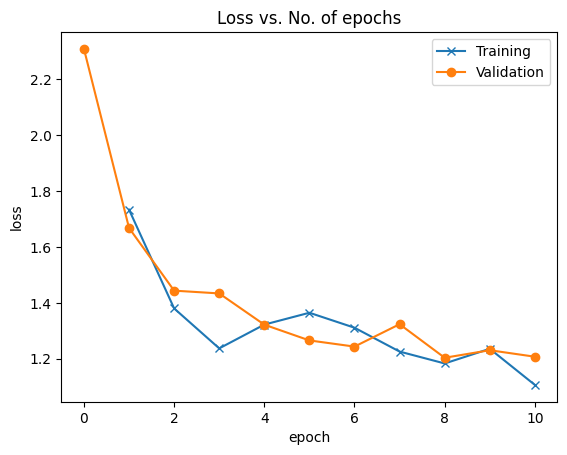

In [44]:
plot_losses([None]+train_losses,[val_loss]+val_losses)

# **8. Testing with individual images**

In [45]:
test_dataset=ImageFolder('/kaggle/input/cifar10/test',transform=ToTensor())

In [47]:
def predict_image(img,model):
    #convert the image to a batch of 1 image
    xb=img.unsqueeze(0)
    #get predictions from model
    yb=model(xb.to(device))
    #pick index with highest probability
    _,preds=torch.max(yb,dim=1) #on recoit l'index
    #retrieve the class label
    return dataset.classes[preds[0].item()]

Label : airplane, Predicted : airplane


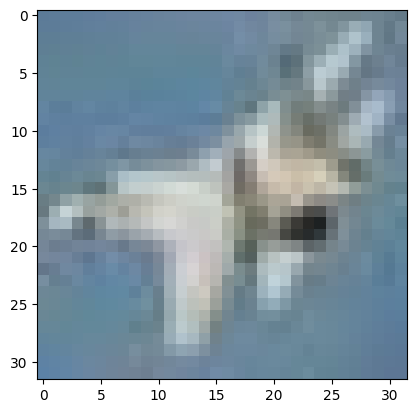

In [49]:
img,label=test_dataset[1]
plt.imshow(img.permute(1,2,0))
print(f'Label : {dataset.classes[label]}, Predicted : {predict_image(img,model)}')

Label : airplane, Predicted : ship


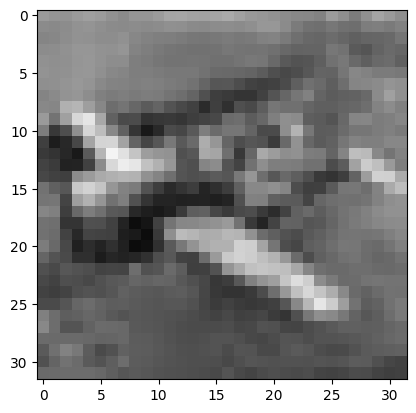

In [51]:
img,label=test_dataset[123]
plt.imshow(img.permute(1,2,0))
print(f'Label : {dataset.classes[label]}, Predicted : {predict_image(img,model)}')

In [56]:
test_dl=DeviceDataLoader(DataLoader(test_dataset,batch_size),device)

test_loss,_,test_acc=evaluate(model,F.cross_entropy,test_dl,metric=accuracy)
print(f'Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')

Loss: 1.1981, Accuracy: 0.5733


# **9. Conclusion and save the model**

On a un bon validation_set et puisque notre accuracy sur le test_dl est proche de notre accuracy sur le val_dl

In [57]:
torch.save(model.state_dict(),'cifar10-cnn.pth')

In [59]:
model2=nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1),

    nn.ReLU(),
    nn.MaxPool2d(2,2), #output : batch_size x 16 x 16 x 16

    nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), #output : bs x 16 x 8 x 8

    nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), #output : bs x 16 x 4 x 4

    nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), #output : bs x 16 x 2 x 2

    nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), #output : bs x 16 x 1 x 1

    nn.Flatten(), #output : bs x 16
    nn.Linear(16,10) #output : bs x 10
)

In [60]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [62]:
test_loss,_,test_acc=evaluate(to_device(model2,device),F.cross_entropy,test_dl,metric=accuracy)
print(f'Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')

Loss: 1.1981, Accuracy: 0.5733
